In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

 
df = pd.read_csv('../../data/Final_divorcio_denuncia.csv')
df.head()


,Departamento,año,Denuncias,Divorcios,Sexo_hombre,Sexo_mujer,0 a 4,5 a 9,10 a 14,15 a 19,...,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad
0,Guatemala,2008,"5,117","1,052",494,"4,623",3,9,28,353,...,752,629,445,308,191,127,73,46,78,52
1,Guatemala,2009,"6,692","1,140",634,"6,058",6,9,44,549,...,"1,237","1,030",763,494,336,208,124,84,151,70
2,Guatemala,2010,"5,792","1,561",517,"5,275",6,9,36,478,...,992,873,614,402,267,161,98,68,121,53
3,Guatemala,2011,"6,122","1,798",531,"5,591",6,8,38,520,...,"1,060",948,698,440,299,189,114,80,143,74
4,Guatemala,2012,"6,911","2,152",568,"6,343",4,16,49,679,...,"1,374","1,224",886,563,357,236,141,97,177,93


# Limpieza de datos

In [23]:
# Eliminar filas de totales nacionales si existen
df = df[df['Departamento'] != 'República']

# Reemplazar comas por nada y convertir a entero
cols_numericas = df.columns.drop('Departamento')
df[cols_numericas] = df[cols_numericas].replace(',', '', regex=True).astype(int)

# Crear la variable objetivo: "Categoria_Divorcios"
promedio_nacional = df['Denuncias'].mean()
df['Categoria_Denuncias'] = df['Denuncias'].apply(
    lambda x: 'alto' if x > promedio_nacional else ('bajo' if x < promedio_nacional else 'neutro')
)

Analisis de correlacion entre variables en SVM_departamentos_year.ipynb

In [38]:
# Verificar valores únicos
df['Categoria_Denuncias'].value_counts()


Categoria_Denuncias
bajo    319
alto     41
Name: count, dtype: int64

# Modelo de Regresion Logistica

In [30]:
# Variables X e y
X = df.drop(columns=['Departamento', 'Categoria_Denuncias', 'Denuncias'])  # No usamos Denuncias porque define la etiqueta
y = df['Categoria_Denuncias']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de la clase
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

c:\Users\josue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Mejor modelo LogReg:
Parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy en test: 1.0
Accuracy promedio (CV): 1.0


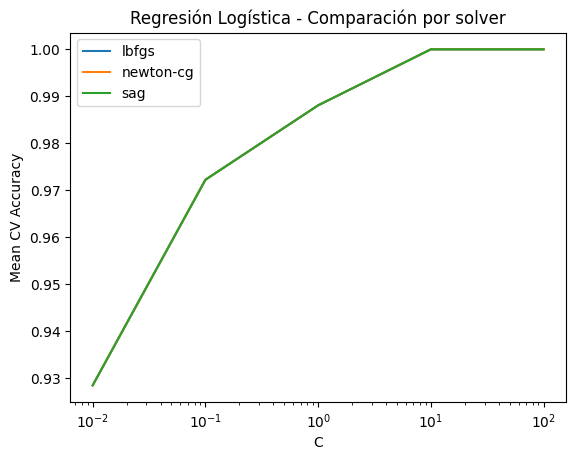

In [31]:
# Definir el modelo base
modelo = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Definir el grid de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l1' y 'elasticnet' requieren el solver 'saga'
    'solver': ['lbfgs', 'newton-cg', 'sag']
}

# Configurar la búsqueda en malla
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Resultados
best_accuracy = grid_search.score(X_test, y_test)
best_params = grid_search.best_params_

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

print("Mejor modelo LogReg:")
print("Parámetros:", best_params)
print("Accuracy en test:", best_accuracy)
print("Accuracy promedio (CV):", grid_search.best_score_)

for solver in param_grid['solver']:
    subset = cv_results[cv_results['param_solver'] == solver]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=solver)

plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Mean CV Accuracy')
plt.title('Regresión Logística - Comparación por solver')
plt.legend()
plt.show()


Accuracy: 1.0
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       1.00      1.00      1.00        12
        bajo       1.00      1.00      1.00        96

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



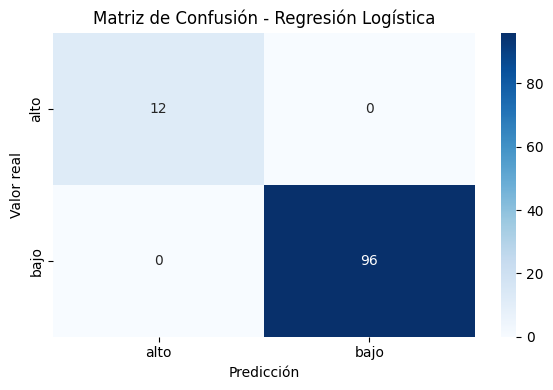

In [32]:
# Entrenar el modelo con los mejores parámetros
mejor_modelo = LogisticRegression(
    C=10,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000
)

mejor_modelo.fit(X_train, y_train)

# Predicción
y_pred = mejor_modelo.predict(X_test)

# Métricas
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.tight_layout()
plt.show()
